# Approach: Undersampling + Underbagging  
# Representation: word2vec 

In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix,auc,roc_curve,matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Load dataset

In [0]:
df = pd.read_csv('../ML_Project_ETL_EDA/Twitter_EDA_Dataset/10k_cleaned.csv')

print("Before dropping null values:",str(df.shape[0]))
df = df.dropna(subset=['cleaned_text'])
print("After dropping null values:",str(df.shape[0]))

Before dropping null values: 17267
After dropping null values: 17267


# Split into training and testing set

In [0]:
X = df['cleaned_text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Training the word2vec model

Train the model

In [0]:
all_content_train = []
for em in X.values:
    all_content_train.append(em.split())

In [0]:
# Define and train model
w2v_model = Word2Vec(all_content_train,min_count = 1)

In [0]:
# from gensim.test.utils import get_tmpfile
# path = get_tmpfile("word2vec.model")
# w2v_model.save(path)

# Alternatively, load the pre-trained model (saved from previous training)

In [0]:
# Trained model for twitter
# w2v_model = Word2Vec.load('..\Trained Embeddings\word2vec-twitter\word2vec.model')

# Trained model for reviews
# w2v_model = Word2Vec.load('..\Trained Embeddings\word2vec-reviews\word2vec(reviews).model')

# Average the embeddings of all words in our sentence to get the sentence embeddings

In [0]:
def avg_sentence_vector(words, model, num_features, vocab):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0

    for word in words:
        if word in vocab:
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [0]:
num_features = w2v_model.vector_size
vocab_list = list(w2v_model.wv.vocab)

df_emb = pd.DataFrame({'text':X_train,
                       'sentiment' : y_train,
                        'embeddings':X_train.str.split().apply(avg_sentence_vector,model=w2v_model,num_features = num_features,vocab = vocab_list)})
df_maj = df_emb.loc[df_emb['sentiment'] == 1]
df_min = df_emb.loc[df_emb['sentiment'] == 0]

C:\Users\Junrong\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


# Clustering the majority class

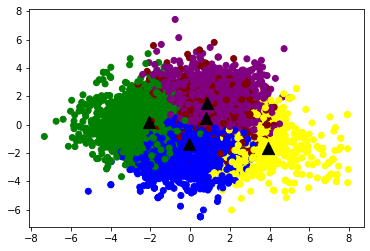

In [0]:
#Cluster majority class only
majority_emb = list(df_maj['embeddings'])

kmeans_model = KMeans(n_clusters=5, init='k-means++', max_iter=100) 
X = kmeans_model.fit(majority_emb)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(majority_emb)

#PCA so we are able to visualize data on a graph
pca = PCA(n_components=2).fit(majority_emb)
datapoint = pca.transform(majority_emb)

plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080','#800000']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()


# Get ratio of the classes
We get the ratio of the class ratios so that we can downsample to this ratio later on to match the size of the miniority class

In [0]:
Class_ratio = df_emb.sentiment.value_counts()
ratio = Class_ratio[0]/Class_ratio[1]

# Train the bagging ensembles

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
#Our cluster size definitely wont be even everytime. Thus we will take X% (ratio of minority to majority class) 
#of the data points of each cluster, and form a new bootstrap sample. Sampling with replacement.  
df_maj['cluster'] = labels

#for every cluster, randomly select X% with replacement, put in a dataframe tgt with min class. Repeat 10 times to get our 10 bootstrap samples
#Then train each sample on 1 classifier (i.e. total we will have 10 classifiers)

X_test_emb = X_test.str.split().apply(avg_sentence_vector,model=w2v_model,num_features = num_features,vocab = vocab_list)
y_pred_soft = 0
y_pred_hard = 0
clf = SVC(kernel='linear',probability=True)

#Set base estimators to be 5 (change accordingly if needed)
num_estimators = 5
for i in range(num_estimators):
#     select X% for every cluster 
#     join with min class
#     train on a classifier
#     predict on test set
#     store output somewhere
    
    df_bootstrap = df_min.copy()
    for i in range(5):
        df_bootstrap = df_bootstrap.append(df_maj[df_maj['cluster'] == i].sample(frac = ratio))

    #if u want to check how many samples we are taking from each cluster
    # print(df_bootstrap[df_bootstrap.sentiment == 1].cluster.value_counts())

    X = df_bootstrap['embeddings']
    y = df_bootstrap['sentiment']
    clf.fit(list(X), y)
    y_pred_hard += clf.predict(list(X_test_emb))
    y_pred_soft += clf.predict_proba(list(X_test_emb))


# Perform a soft voting aggregation method on all our classifiers

In [0]:
def PlotROC(y_test,pred):
    
    fpr, tpr, threshold = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return roc_auc


def PrintStats(y_test, pred):
    
    f1Score = round(f1_score(y_test, pred), 2)
    recallScore = round(recall_score(y_test, pred), 2)
    precscore = round(precision_score(y_test, pred), 2)
    mcc = round(matthews_corrcoef(y_test, pred), 2)
    print("Precision for Model : {prec_score}".format(prec_score = precscore))
    print("Sensitivity/Recall for Model : {recall_score}".format(recall_score = recallScore))
    print("F1 Score for Model : {f1_score}".format(f1_score = f1Score))
    print("MCC Score for Model : {mcc_score}".format(mcc_score = mcc))

Precision for Model : 0.96
Sensitivity/Recall for Model : 0.76
F1 Score for Model : 0.85
MCC Score for Model : 0.32


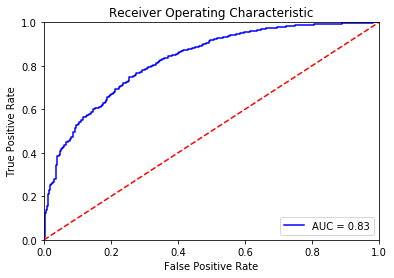

0.8275286778649367

In [0]:
y_pred_soft = y_pred_soft/num_estimators
y_pred_final = []
for i in y_pred_soft:
    if i[0] > i[1]:
        y_pred_final.append(0)
    else:
        y_pred_final.append(1)
        
PrintStats(y_test,y_pred_final)
PlotROC(y_test,y_pred_soft[:,1])